# 3b Lasso and Ridge Linear Regression with Cross-validation

#### It has four main sections

## A. Imports, data shaping, and preprocessing

## B. Lasso CV regression on all features

## C. Lasso and Ridge regression on all features except `rating count`

## D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

# A. Imports and data shaping

In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
pd.options.display.float_format = "{:,.5f}".format

In [3]:
#director = 'godard'
#director = 'hitchcock'
#director = 'bergman'
#director = 'fassbinder'
#director = 'herzog'
#director = 'scorsese'
director='allen'

In [4]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director +'.pickle'
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [5]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,"2,020.00000",2 October 2020 (Spain),92.00000,92.00000,NaN,"1,301,430.00000","512,116.00000","1,301,430.00000",6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,A Rainy Day in New York,"2,019.00000",10 November 2020 (USA),92.00000,92.00000,NaN,"18,182,784.00000","22,002,504.00000","18,182,784.00000",6.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Wonder Wheel,"2,017.00000",15 December 2017 (USA),101.00000,101.00000,"25,000,000.00000","13,736,872.00000","15,889,124.00000","13,736,872.00000",6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Café Society,"2,016.00000",5 August 2016 (USA),96.00000,96.00000,"30,000,000.00000","43,763,247.00000","43,763,247.00000",NaN,6.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Irrational Man,"2,015.00000",7 August 2015 (USA),95.00000,95.00000,"11,000,000.00000","29,083,597.00000","27,391,084.00000","29,083,597.00000",6.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [6]:
prevalent_actors_filename  = 'prevalent_actors_' + director +'.pickle'
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [7]:
prevalent_actor_columns

Index(['Woody Allen', 'Mia Farrow', 'Diane Keaton', 'Maurice Sonnenberg',
       'Wallace Shawn', 'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

In [8]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [9]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [10]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Woody Allen',
 'Mia Farrow',
 'Diane Keaton',
 'Maurice Sonnenberg',
 'Wallace Shawn',
 'Stephanie Roth Haberle',
 'Dan Frazer',
 'Julie Kavner',
 'John Doumanian',
 'Tony Roberts',
 'Alan Alda',
 'Paul Herman',
 'Ira Wheeler',
 'Dianne Wiest',
 'Louise Lasser',
 'Douglas McGrath',
 'Scarlett Johansson',
 'Sam Waterston']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [11]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Radha Mitchell,Michael J. Farina,Jonny Lee Miller,Chloë Sevigny,Matt Servitto,Arija Bareikis,Brooke Smith,Zak Orth,Will Ferrell,Akiko Wakabayashi
0,Rifkin's Festival,"2,020.00000",2 October 2020 (Spain),92.00000,92.00000,NaN,"1,301,430.00000","512,116.00000","1,301,430.00000",6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,A Rainy Day in New York,"2,019.00000",10 November 2020 (USA),92.00000,92.00000,NaN,"18,182,784.00000","22,002,504.00000","18,182,784.00000",6.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Wonder Wheel,"2,017.00000",15 December 2017 (USA),101.00000,101.00000,"25,000,000.00000","13,736,872.00000","15,889,124.00000","13,736,872.00000",6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Café Society,"2,016.00000",5 August 2016 (USA),96.00000,96.00000,"30,000,000.00000","43,763,247.00000","43,763,247.00000",NaN,6.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Irrational Man,"2,015.00000",7 August 2015 (USA),95.00000,95.00000,"11,000,000.00000","29,083,597.00000","27,391,084.00000","29,083,597.00000",6.60000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [12]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [13]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Woody Allen,Mia Farrow,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
0,Rifkin's Festival,"2,020.00000",92.00000,Vittorio Storaro,0.00000,0.00000,6.20000,723.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
1,A Rainy Day in New York,"2,019.00000",92.00000,Vittorio Storaro,0.00000,0.00000,6.50000,"30,151.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Wonder Wheel,"2,017.00000",101.00000,Vittorio Storaro,0.00000,0.00000,6.20000,"25,209.00000",0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Café Society,"2,016.00000",96.00000,Vittorio Storaro,0.00000,0.00000,6.60000,"71,114.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Irrational Man,"2,015.00000",95.00000,Darius Khondji,0.00000,0.00000,6.60000,"58,704.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [14]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [15]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [16]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Woody Allen', 'Mia Farrow',
       'Diane Keaton', 'Maurice Sonnenberg', 'Wallace Shawn',
       'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

In [17]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [18]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Woody Allen',
 'Mia Farrow',
 'Diane Keaton',
 'Maurice Sonnenberg',
 'Wallace Shawn',
 'Stephanie Roth Haberle',
 'Dan Frazer',
 'Julie Kavner',
 'John Doumanian',
 'Tony Roberts',
 'Alan Alda',
 'Paul Herman',
 'Ira Wheeler',
 'Dianne Wiest',
 'Louise Lasser',
 'Douglas McGrath',
 'Scarlett Johansson',
 'Sam Waterston']

In [19]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [20]:
y.isnull().values.any()

False

### Train-val vs. test split

In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [22]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Woody Allen,Mia Farrow,Diane Keaton,Maurice Sonnenberg,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
21,"2,001.00000",103.00000,Fei Zhao,0.00000,0.00000,"37,740.00000",1.00000,0.00000,0.00000,1.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
43,"1,982.00000",88.00000,Gordon Willis,0.00000,0.00000,"18,440.00000",1.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
49,"1,973.00000",89.00000,David M. Walsh,0.00000,0.00000,"39,747.00000",1.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
13,"2,007.00000",108.00000,Vilmos Zsigmond,0.00000,0.00000,"49,986.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
45,"1,979.00000",96.00000,Gordon Willis,0.00000,0.00000,"131,301.00000",1.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"2,014.00000",97.00000,Darius Khondji,0.00000,0.00000,"64,032.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
18,"2,002.00000",112.00000,OTHER,0.00000,0.00000,"25,820.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
53,"1,969.00000",85.00000,OTHER,0.00000,0.00000,"28,204.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"2,016.00000",96.00000,Vittorio Storaro,0.00000,0.00000,"71,114.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
34,"1,989.00000",104.00000,Sven Nykvist,0.00000,0.00000,"54,605.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [23]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [24]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [25]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Carlo Di Palma', 'cinematographer_Darius Khondji',
       'cinematographer_David M. Walsh', 'cinematographer_Fei Zhao',
       'cinematographer_Gordon Willis',
       'cinematographer_Javier Aguirresarobe', 'cinematographer_OTHER',
       'cinematographer_Remi Adefarasin', 'cinematographer_Sven Nykvist',
       'cinematographer_Vilmos Zsigmond',
       'cinematographer_Vittorio Storaro'], dtype=object)

In [26]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,cinematographer_Javier Aguirresarobe,cinematographer_OTHER,cinematographer_Remi Adefarasin,cinematographer_Sven Nykvist,cinematographer_Vilmos Zsigmond,cinematographer_Vittorio Storaro
9,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
28,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
36,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
5,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Repeating transformations on testing set

In [27]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [28]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
9,"2,011.00000",94.00000,"387,522.00000"
28,"1,994.00000",100.00000,"3,178.00000"
7,"2,013.00000",98.00000,"191,782.00000"
36,"1,988.00000",81.00000,"12,898.00000"
5,"2,015.00000",95.00000,"58,704.00000"


In [29]:
#X_train_val_cont_poly.head()

In [30]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-30-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-30-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-30-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [31]:
X_test_cont.shape[0]

11

#### Concatenate columns

In [32]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [33]:
X_test_cat_df.isnull().values.any()

False

In [34]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [35]:
X_test_cat_df.shape

(11, 20)

In [36]:
X_train_val_combo.isnull().values.any()

False

In [37]:
X_test_combo.isnull().values.any()

False

In [38]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
0,"2,001.00000",103.00000,"37,740.00000",7.60140,10.53848,0.00000,0.00000,0.00000,1.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,982.00000",88.00000,"18,440.00000",7.59186,9.82228,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,973.00000",89.00000,"39,747.00000",7.58731,10.59029,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"2,007.00000",108.00000,"49,986.00000",7.60440,10.81950,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,979.00000",96.00000,"131,301.00000",7.59035,11.78525,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"2,014.00000",97.00000,"64,032.00000",7.60788,11.06714,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"2,002.00000",112.00000,"25,820.00000",7.60190,10.15890,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
7,"1,969.00000",85.00000,"28,204.00000",7.58528,10.24722,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,"2,016.00000",96.00000,"71,114.00000",7.60887,11.17204,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"1,989.00000",104.00000,"54,605.00000",7.59539,10.90788,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


In [39]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Carlo Di Palma', 'cinematographer_Darius Khondji',
       'cinematographer_David M. Walsh', 'cinematographer_Fei Zhao',
       'cinematographer_Gordon Willis', 'cinematographer_Javier Aguirresarobe',
       'cinematographer_OTHER', 'cinematographer_Remi Adefarasin',
       'cinematographer_Sven Nykvist', 'cinematographer_Vilmos Zsigmond',
       'cinematographer_Vittorio Storaro', 'documentary', 'tv_series',
       'Woody Allen', 'Mia Farrow', 'Diane Keaton', 'Maurice Sonnenberg',
       'Wallace Shawn', 'Stephanie Roth Haberle', 'Dan Frazer', 'Julie Kavner',
       'John Doumanian', 'Tony Roberts', 'Alan Alda', 'Paul Herman',
       'Ira Wheeler', 'Dianne Wiest', 'Louise Lasser', 'Douglas McGrath',
       'Scarlett Johansson', 'Sam Waterston'],
      dtype='object')

### Train vs. val split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [41]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

## B. Lasso CV regression on all features


### Lasso CV

In [42]:
X_train_val_combo.values

array([[2.01100e+03, 9.40000e+01, 3.87522e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.99400e+03, 1.00000e+02, 3.17800e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.01300e+03, 9.80000e+01, 1.91782e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.00500e+03, 1.24000e+02, 2.06093e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [1.99300e+03, 1.04000e+02, 3.99440e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.98500e+03, 8.20000e+01, 4.70420e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [43]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [44]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [45]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [46]:
# This is the best alpha value it found 
lasso_model.alpha_

0.09221978823334327

In [47]:
len(lasso_model.coef_)

36

In [48]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', -0.03773238883238906),
 ('duration', -0.0),
 ('rating_count', 0.00355332771450401),
 ('log_year', -0.0),
 ('log_rating_count', 0.2251617335687818),
 ('cinematographer_Carlo Di Palma', 0.020532767962221983),
 ('cinematographer_Darius Khondji', -0.007405055278465474),
 ('cinematographer_David M. Walsh', -0.0),
 ('cinematographer_Fei Zhao', 0.0),
 ('cinematographer_Gordon Willis', 0.11545285751710795),
 ('cinematographer_Javier Aguirresarobe', 0.0),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Remi Adefarasin', 0.0),
 ('cinematographer_Sven Nykvist', -0.0),
 ('cinematographer_Vilmos Zsigmond', -0.026680464205754328),
 ('cinematographer_Vittorio Storaro', -0.0),
 ('documentary', -0.0),
 ('tv_series', -0.0),
 ('Woody Allen', 0.0),
 ('Mia Farrow', 0.017341185036757023),
 ('Diane Keaton', 0.039367987597113976),
 ('Maurice Sonnenberg', -0.0),
 ('Wallace Shawn', 0.0),
 ('Stephanie Roth Haberle', 0.0),
 ('Dan Frazer', 0.0),
 ('Julie Kavner', 0.0),
 ('John Doumanian', 0.0),
 ('T

In [49]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [50]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.360647396047078

In [51]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.2947382400703549

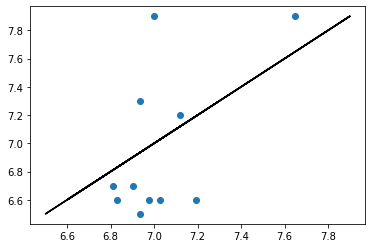

In [52]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

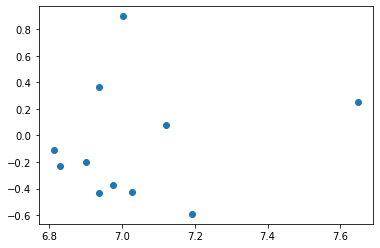

In [53]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [54]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
4,log_rating_count,0.22516
9,cinematographer_Gordon Willis,0.11545
20,Diane Keaton,0.03937
0,year,-0.03773
14,cinematographer_Vilmos Zsigmond,-0.02668
5,cinematographer_Carlo Di Palma,0.02053
19,Mia Farrow,0.01734
6,cinematographer_Darius Khondji,-0.00741
2,rating_count,0.00355
32,Louise Lasser,-0.00032


In [55]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.360647396047078,
 'coefficients':                                  Feature  Coefficient
 4                       log_rating_count      0.22516
 9          cinematographer_Gordon Willis      0.11545
 20                          Diane Keaton      0.03937
 0                                   year     -0.03773
 14       cinematographer_Vilmos Zsigmond     -0.02668
 5         cinematographer_Carlo Di Palma      0.02053
 19                            Mia Farrow      0.01734
 6         cinematographer_Darius Khondji     -0.00741
 2                           rating_count      0.00355
 32                         Louise Lasser     -0.00032
 24                            Dan Frazer      0.00000
 25                          Julie Kavner      0.00000
 26                        John Doumanian      0.00000
 27                          Tony Rober

In [56]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_' + director +'.pickle'
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

# C. Lasso and Ridge regression on all features except `rating count`



### Rerun the model without using rating count

In [57]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Carlo Di Palma,cinematographer_Darius Khondji,cinematographer_David M. Walsh,cinematographer_Fei Zhao,cinematographer_Gordon Willis,...,John Doumanian,Tony Roberts,Alan Alda,Paul Herman,Ira Wheeler,Dianne Wiest,Louise Lasser,Douglas McGrath,Scarlett Johansson,Sam Waterston
0,1.16335,-0.20590,4.14570,1.16194,2.02484,-0.64327,3.04138,-0.15811,-0.22646,-0.41404,...,-0.28098,-0.22646,-0.22646,-0.28098,-0.28098,-0.28098,-0.28098,-0.22646,-0.22646,-0.22646
1,-0.07083,-0.02238,-0.69912,-0.06738,-1.80093,1.55456,-0.32880,-0.15811,-0.22646,-0.41404,...,-0.28098,-0.22646,-0.22646,-0.28098,-0.28098,-0.28098,-0.28098,-0.22646,-0.22646,-0.22646
2,1.30855,-0.08355,1.67832,1.30588,1.46460,-0.64327,-0.32880,-0.15811,-0.22646,-0.41404,...,-0.28098,-0.22646,-0.22646,-0.28098,-0.28098,-0.28098,-0.28098,-0.22646,-0.22646,-0.22646
3,-0.50642,-0.60352,-0.57659,-0.50376,-0.68525,-0.64327,-0.32880,-0.15811,-0.22646,-0.41404,...,-0.28098,-0.22646,-0.22646,-0.28098,-0.28098,-0.28098,-0.28098,-0.22646,-0.22646,-0.22646
4,1.45375,-0.17531,0.00081,1.44968,0.52172,-0.64327,3.04138,-0.15811,-0.22646,-0.41404,...,-0.28098,-0.22646,-0.22646,-0.28098,-0.28098,-0.28098,-0.28098,-0.22646,-0.22646,-0.22646


In [58]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [59]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [60]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [61]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

0.12750512407130135

In [62]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

In [63]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [64]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.390439341655415

In [65]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


0.18379561625527174

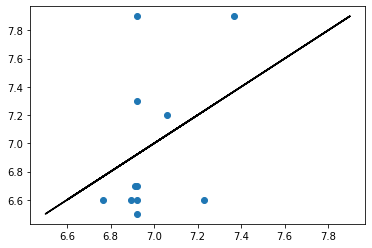

In [66]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

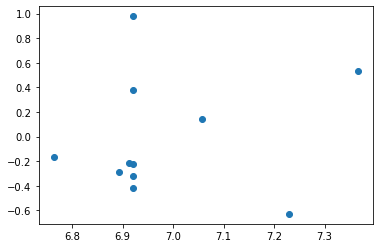

In [67]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [68]:
coefficients_df.head()

,Feature,Coefficient
7,cinematographer_Gordon Willis,0.10912
18,Diane Keaton,0.04059
25,Tony Roberts,0.00000
19,Maurice Sonnenberg,-0.00000
20,Wallace Shawn,-0.00000


In [69]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.390439341655415,
 'coefficients':                                  Feature  Coefficient
 7          cinematographer_Gordon Willis      0.10912
 18                          Diane Keaton      0.04059
 25                          Tony Roberts      0.00000
 19                    Maurice Sonnenberg     -0.00000
 20                         Wallace Shawn     -0.00000
 21                Stephanie Roth Haberle     -0.00000
 22                            Dan Frazer      0.00000
 23                          Julie Kavner      0.00000
 24                        John Doumanian      0.00000
 0                                   year     -0.00000
 1                               duration     -0.00000
 27                           Paul Herman      0.00000
 28                           Ira Wheeler     -0.00000
 29                          Dianne Wie

In [70]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [71]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


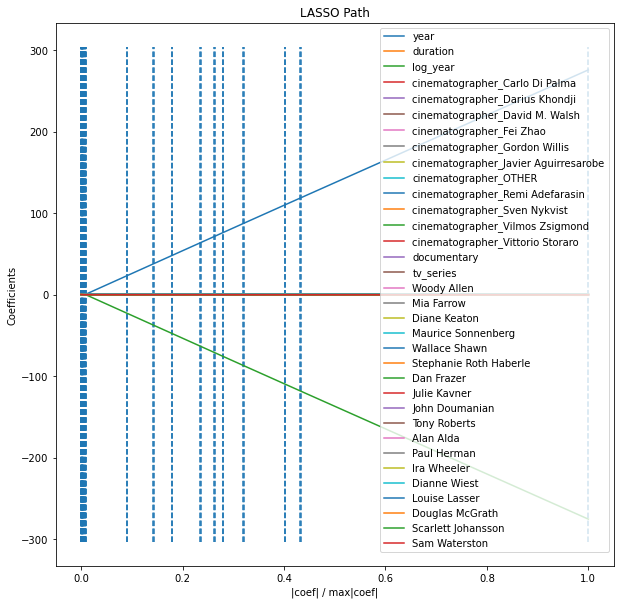

In [72]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [73]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

79.34096665797492

In [74]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
7,cinematographer_Gordon Willis,0.05885
18,Diane Keaton,0.05803
15,tv_series,-0.04713
13,cinematographer_Vittorio Storaro,-0.04489
30,Louise Lasser,-0.04442
12,cinematographer_Vilmos Zsigmond,-0.03970
31,Douglas McGrath,-0.03845
28,Ira Wheeler,-0.03370
10,cinematographer_Remi Adefarasin,0.03302
29,Dianne Wiest,0.02876


In [75]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [76]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3489248855290873

In [77]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


0.10698811417156662

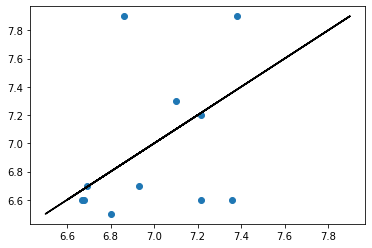

In [78]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

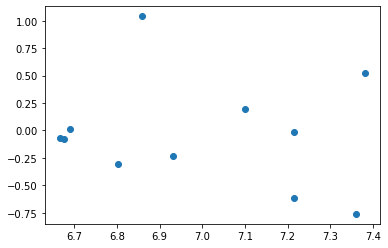

In [79]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [80]:
coefficients_df.head()

,Feature,Coefficient
7,cinematographer_Gordon Willis,0.05885
18,Diane Keaton,0.05803
15,tv_series,-0.04713
13,cinematographer_Vittorio Storaro,-0.04489
30,Louise Lasser,-0.04442


In [81]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3489248855290873,
 'coefficients':                                  Feature  Coefficient
 7          cinematographer_Gordon Willis      0.05885
 18                          Diane Keaton      0.05803
 15                             tv_series     -0.04713
 13      cinematographer_Vittorio Storaro     -0.04489
 30                         Louise Lasser     -0.04442
 12       cinematographer_Vilmos Zsigmond     -0.03970
 31                       Douglas McGrath     -0.03845
 28                           Ira Wheeler     -0.03370
 10       cinematographer_Remi Adefarasin      0.03302
 29                          Dianne Wiest      0.02876
 1                               duration     -0.02785
 0                                   year     -0.02753
 2                               log_year     -0.02738
 25                          Tony Robe

In [82]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

# D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

#### Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [83]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [84]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [85]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Woody Allen',
 'Mia Farrow',
 'Diane Keaton',
 'Maurice Sonnenberg',
 'Wallace Shawn',
 'Stephanie Roth Haberle',
 'Dan Frazer',
 'Julie Kavner',
 'John Doumanian',
 'Tony Roberts',
 'Alan Alda',
 'Paul Herman',
 'Ira Wheeler',
 'Dianne Wiest',
 'Louise Lasser',
 'Douglas McGrath',
 'Scarlett Johansson',
 'Sam Waterston']

In [86]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [87]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [88]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [89]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Woody Allen', 'Mia Farrow', 'Diane Keaton',
       'Maurice Sonnenberg', 'Wallace Shawn', 'Stephanie Roth Haberle',
       'Dan Frazer', 'Julie Kavner', 'John Doumanian', 'Tony Roberts',
       'Alan Alda', 'Paul Herman', 'Ira Wheeler', 'Dianne Wiest',
       'Louise Lasser', 'Douglas McGrath', 'Scarlett Johansson',
       'Sam Waterston'],
      dtype='object')

In [90]:
#selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [91]:
selected_cols = films_and_features_to_analyze_df.columns[1:4]

In [92]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [93]:
X

,year,duration,budget
2,"2,017.00000",101.00000,"25,000,000.00000"
4,"2,016.00000",96.00000,"30,000,000.00000"
5,"2,015.00000",95.00000,"11,000,000.00000"
6,"2,014.00000",97.00000,"16,800,000.00000"
7,"2,013.00000",98.00000,"18,000,000.00000"
8,"2,012.00000",112.00000,"17,000,000.00000"
9,"2,011.00000",94.00000,"17,000,000.00000"
10,"2,010.00000",98.00000,"22,000,000.00000"
11,"2,009.00000",93.00000,"15,000,000.00000"
12,"2,008.00000",96.00000,"15,500,000.00000"


In [94]:
y.isnull().values.any()

False

In [95]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [96]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

### Continuous Variable Preprocessing

In [97]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
6,"2,014.00000",97.00000,"16,800,000.00000"
9,"2,011.00000",94.00000,"17,000,000.00000"
34,"1,989.00000",104.00000,"19,000,000.00000"
38,"1,987.00000",88.00000,"16,000,000.00000"
25,"1,997.00000",96.00000,"20,000,000.00000"


In [98]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

In [99]:
X_test_cont.shape[0]

9

#### Concatenate columns

In [100]:
X_train_val_combo = X_train_val_cont

In [101]:
X_test_combo = X_test_cont

In [102]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget', 'budget_sq'], dtype='object')

### Train vs. val split



In [103]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [104]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [105]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [106]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [107]:
# This is the best alpha value it found 
lasso_model.alpha_

0.07663410868007459

In [108]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo.columns, lasso_model.coef_))
coefficients

[('year', -0.1562011409593159),
 ('duration', -0.06232945344469144),
 ('budget', -0.0),
 ('log_year', -0.0),
 ('log_budget', 0.0),
 ('budget_sq', -0.0)]

In [109]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [110]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.47371506811691433

In [111]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-1.550315901191622

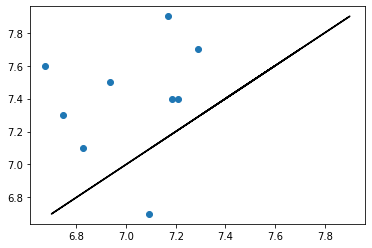

In [112]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

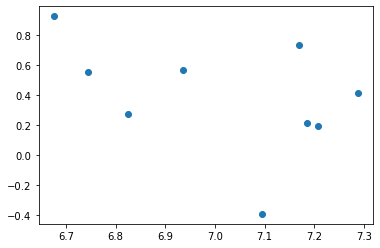

In [113]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [114]:
pd.options.display.float_format = "{:,.5f}".format



In [115]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
0,year,-0.15620
1,duration,-0.06233
2,budget,-0.00000
3,log_year,-0.00000
4,log_budget,0.00000
5,budget_sq,-0.00000


In [116]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.47371506811691433,
 'coefficients':       Feature  Coefficient
 0        year     -0.15620
 1    duration     -0.06233
 2      budget     -0.00000
 3    log_year     -0.00000
 4  log_budget      0.00000
 5   budget_sq     -0.00000}

In [117]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [118]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

26.126752255633292

In [119]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, ridge_model.coef_))


In [120]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [121]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4713224564537548

In [122]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-1.603904971874171

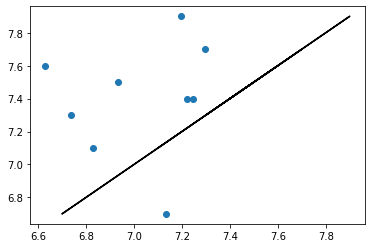

In [123]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

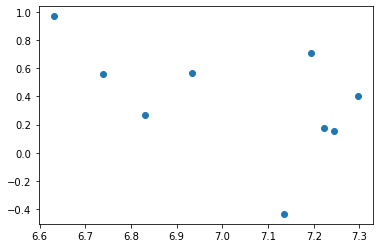

In [124]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [125]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

,Feature,Coefficient
0,year,-0.08601
3,log_year,-0.08560
1,duration,-0.07978
4,log_budget,0.03186
5,budget_sq,-0.01784
2,budget,-0.00168


In [126]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4713224564537548,
 'coefficients':       Feature  Coefficient
 0        year     -0.08601
 3    log_year     -0.08560
 1    duration     -0.07978
 4  log_budget      0.03186
 5   budget_sq     -0.01784
 2      budget     -0.00168}

In [127]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)